In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import nltk, os, re, string
from nltk.corpus import stopwords
import string
import pickle

In [20]:
train = pd.read_csv("../Dataset/twitter_parsed_dataset.csv")

# Data Cleaning

First we have to clean our data as we don't want unwanted words to be part of our vocabulary

In [21]:

train = train.drop(columns=['index','id'])
train.head()

,Text,Annotation,oh_label
0,@halalflaws @biebervalue @greenlinerzjm I read...,none,0.0
1,@ShreyaBafna3 Now you idiots claim that people...,none,0.0
2,"RT @Mooseoftorment Call me sexist, but when I ...",sexism,1.0
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",racism,1.0
4,#mkr No No No No No No,none,0.0


In [22]:
train['Text'] = train['Text'].fillna("")

In [23]:
%%time
# STEPS TAKEN FROM SRK NOTEBOOK
# LOWER CASE ALL CHARACTERS 
train.Text = train.Text.apply(lambda x: x.lower())

## LEMMATIZATION
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
lemmatizer = WordNetLemmatizer()

def lem(text):
    pos_dict = {'N': wn.NOUN, 'V': wn.VERB, 'J': wn.ADJ, 'R': wn.ADV}
    return(' '.join([lemmatizer.lemmatize(w,pos_dict.get(t, wn.NOUN)) for w,t in nltk.pos_tag(text.split())]))

train.Text = train.Text.apply(lambda x: lem(x))

# REMOVING PUNCTUATION
def cleaner(text):
    return(text.translate(str.maketrans('','', string.punctuation)))
train.Text = train.Text.apply(lambda x: cleaner(x))

# REMOVING STOPWORDS
st_words = stopwords.words()
def stopword(text):
    return(' '.join([w for w in text.split() if w not in st_words ]))
train.Text = train.Text.apply(lambda x: stopword(x))

Wall time: 33.8 s


#### Without using Pretrained Vectors 

In [24]:
from keras.layers import Input, LSTM, Bidirectional, SpatialDropout1D, Dropout, Flatten, Dense, Embedding, BatchNormalization
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

Using TensorFlow backend

In [25]:
train = train.reset_index()

In [26]:
train = train.drop(columns=['index'])
train.head()

,Text,Annotation,oh_label
0,halalflaws biebervalue greenlinerzjm read cont...,none,0.0
1,shreyabafna3 idiot claim people tried stop bec...,none,0.0
2,rt mooseoftorment call sexist go auto place id...,sexism,1.0
3,g0ssipsquirrelx wrong follows example mohammed...,racism,1.0
4,mkr,none,0.0


In [27]:
train = train.reset_index(drop=True)
print(train.head())


                                                Text Annotation  oh_label
0  halalflaws biebervalue greenlinerzjm read cont...       none       0.0
1  shreyabafna3 idiot claim people tried stop bec...       none       0.0
2  rt mooseoftorment call sexist go auto place id...     sexism       1.0
3  g0ssipsquirrelx wrong follows example mohammed...     racism       1.0
4                                                mkr       none       0.0


In [28]:
train.oh_label.value_counts

<bound method IndexOpsMixin.value_counts of 0        0.0
1        0.0
2        1.0
3        1.0
4        0.0
        ... 
16846    0.0
16847    0.0
16848    0.0
16849    0.0
16850    0.0
Name: oh_label, Length: 16851, dtype: float64>

In [29]:
train.oh_label.isna().sum()

3

In [30]:
train.oh_label = train.oh_label.fillna(0)

In [31]:
train.oh_label = train.oh_label.astype(int)

In [32]:
train.oh_label.value_counts

<bound method IndexOpsMixin.value_counts of 0        0
1        0
2        1
3        1
4        0
        ..
16846    0
16847    0
16848    0
16849    0
16850    0
Name: oh_label, Length: 16851, dtype: int32>

In [33]:
train_label = to_categorical(train.oh_label,num_classes=2)
train_label.shape

(16851, 2)

In [34]:
max_words = 40000
max_len = 256

tok = Tokenizer(lower=True, char_level=False)
tok.fit_on_texts(train.Text)
pickle.dump(tok, open("../Model/token.pickle", "wb"))
sequence = tok.texts_to_sequences(train.Text)
sequence = pad_sequences(padding='post', sequences=sequence, maxlen= max_len)
sequence.shape

(16851, 256)

In [35]:
sequence

array([[  158,   210,    91, ...,     0,     0,     0],
       [ 5325,   168,   271, ...,     0,     0,     0],
       [    2, 10364,    34, ...,     0,     0,     0],
       ...,
       [    2,  1266,   237, ...,     0,     0,     0],
       [ 1801,   998,    91, ...,     0,     0,     0],
       [ 1683,    45,   752, ...,     0,     0,     0]])

In [36]:
def modeling():
    inp = Input(shape=(max_len,))
    x = Embedding(max_words, 300 ,input_length = max_len)(inp)
    x = Bidirectional(LSTM(256, return_sequences=True))(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.5)(x)
    x = Flatten()(x)
    x = Dense(128, activation= 'relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(2, activation='softmax')(x)
    model = Model(inputs = inp, outputs = x)
    return(model)

In [37]:
model = modeling()
model.compile(optimizer = 'adam', metrics = ['accuracy'], loss= 'binary_crossentropy')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256)]             0         
                                                                 
 embedding (Embedding)       (None, 256, 300)          12000000  
                                                                 
 bidirectional (Bidirectiona  (None, 256, 512)         1140736   
 l)                                                              
                                                                 
 batch_normalization (BatchN  (None, 256, 512)         2048      
 ormalization)                                                   
                                                                 
 spatial_dropout1d (SpatialD  (None, 256, 512)         0         
 ropout1D)                                                       
                                                             

In [38]:
lr = ReduceLROnPlateau(monitor='valid_set', factor=0.002, min_lr=0.00001)
model.fit(sequence, train_label, validation_split=0.30, callbacks=[lr], batch_size=64, epochs=10)

Epoch 1/10
185/185 [==============================] - 40s 182ms/step - loss: 0.5913 - accuracy: 0.7340 - val_loss: 0.5516 - val_accuracy: 0.6924 - lr: 0.0010
Epoch 2/10
185/185 [==============================] - 34s 181ms/step - loss: 0.2694 - accuracy: 0.8994 - val_loss: 3.2634 - val_accuracy: 0.3125 - lr: 0.0010
Epoch 3/10
185/185 [==============================] - 34s 182ms/step - loss: 0.1498 - accuracy: 0.9480 - val_loss: 11.3975 - val_accuracy: 0.6879 - lr: 0.0010
Epoch 4/10
185/185 [==============================] - 34s 182ms/step - loss: 0.1035 - accuracy: 0.9669 - val_loss: 0.6833 - val_accuracy: 0.8360 - lr: 0.0010
Epoch 5/10
185/185 [==============================] - 34s 182ms/step - loss: 0.0796 - accuracy: 0.9747 - val_loss: 0.5710 - val_accuracy: 0.8303 - lr: 0.0010
Epoch 6/10
185/185 [==============================] - 34s 182ms/step - loss: 0.0555 - accuracy: 0.9819 - val_loss: 1.2300 - val_accuracy: 0.5344 - lr: 0.0010
Epoch 7/10
185/185 [==============================]

Text(0, 0.5, 'Accuracy')

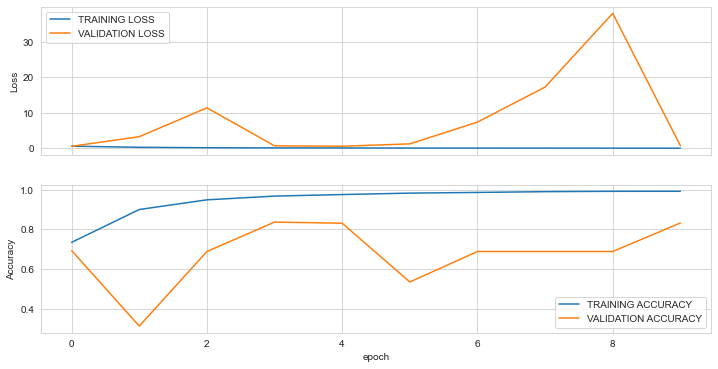

In [39]:
performance_WO = pd.DataFrame({'epoch': model.history.epoch, 'loss': model.history.history['loss'], 
              'val_loss': model.history.history['val_loss'], 'acc': model.history.history['accuracy'],
             'val_acc': model.history.history['val_accuracy']})

fig, ax = plt.subplots(2,1, figsize=(12,6), sharex = True)  
sns.lineplot(x= 'epoch', y= 'loss', data = performance_WO, ax= ax[0])
sns.lineplot(x= 'epoch', y= 'val_loss', data = performance_WO, ax = ax[0])
ax[0].legend(['TRAINING LOSS', 'VALIDATION LOSS'])
ax[0].set_ylabel('Loss')

  
sns.lineplot(x= 'epoch', y= 'acc', data = performance_WO, ax= ax[1])
sns.lineplot(x= 'epoch', y= 'val_acc', data = performance_WO, ax = ax[1])
ax[1].legend(['TRAINING ACCURACY', 'VALIDATION ACCURACY'])
ax[1].set_ylabel('Accuracy')

# Save the Model

In [46]:
model.save('../Model/CyberBully_DL_Model.h5')